In [2]:
from werkzeug.wrappers import Request, Response
#from flask import Flask, render_template
from jinja2 import Template

#from datetime import date
from datetime import datetime, timedelta

import collections
from amigocloud import AmigoCloud

from datetime import datetime

from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]

In [3]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [4]:
def generar_reporte(codigo_canhero):
    # EXTRAER DATOS DE CREDITO
    query_credito = {'query': 'select * from dataset_307560 where cast(SPLIT_PART(canhero, \'/\', 1) as integer) = {cod_ca}'.format(cod_ca=codigo_canhero)}
    credito_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_credito)
    credito_data = credito_select['data'][0]
    credito_data['fecha_informe'] = datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
    credito_data['fecha_2da_insp'] = datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
    credito = collections.namedtuple("credito", credito_data.keys())(*credito_data.values())

    # EXTRAER DATOS DE PROPIEDADES
    # query_propiedades = {'query': 'select * from dataset_282968 where cre_ref_prop = \'{cre_ref_prop}\''.format(cre_ref_prop=credito.amigo_id)}
    query_propiedades = {'query': 'select prop.propiedad, prop.amigo_id from dataset_307562 prop inner join dataset_307563 lotes on lotes.prop_ref_lote=prop.amigo_id where insp_ref_prop=\'{cre_ref_prop}\' and (lotes.estado_de_siembra=\'CAÑA NACIDA\' or lotes.estado_de_siembra=\'CAÑA NO NACIDA\') group by prop.propiedad, prop.amigo_id'.format(cre_ref_prop=credito.amigo_id)}
    propiedades_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_propiedades)    
    
    propiedades_data = propiedades_select['data']

    # EXTRAER DATOS DE LOTES
    propiedades = []
    for prop in propiedades_data:
        prop['lotes'] = []
        query_lotes = {'query': 'select * from dataset_307563 where prop_ref_lote=\'{prop_ref_lote}\' and (estado_de_siembra=\'CAÑA NACIDA\' or estado_de_siembra=\'CAÑA NO NACIDA\')'.format(prop_ref_lote=prop['amigo_id'])}
        lotes_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_lotes)
        for lote_select in lotes_select['data']:
            lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
            prop['lotes'].append(lote)
        propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))

    # EXTRAER FOTOS
    fotos = []
    for propiedad in propiedades:
        for lote in propiedad.lotes:
            print(lote.lote, lote.amigo_id)
            query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_48961 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
            fotos_filename = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_fotos)
            if fotos_filename['data'] != []:
                dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
                fotos.append(dic)

    # GENERERAR PLANOS
    i = 0
    lista_planos = []
    for propiedad in propiedades:
        i = i + 1
        lista_planos.append(generar_plano(propiedad, i))


    # GENERAR REPORTE
    doc = DocxTemplate(ruta + "/templates/tpl_inf_credito_2da.docx")
    #generar lista de InlineImage de planos 
    lista_InlineImage = []
    for plano in lista_planos:
        lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))
    #descargar fotos y generar lista InlineImage
    lista_fotos_inline = []
    for foto in fotos:
        #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        file = open(ruta + '/fotos/' + foto['file_name'], "wb")
        file.write(response.content)
        file.close()
        lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor=ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})
    firma_respon = None
    if credito.respon_2da_insp == 'Juan Pablo Jaldin Duran':
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))
    else:
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
    context = {'credito':credito, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}
    doc.render(context)
    cod_ca = credito.canhero.split(' / ')[0]
    nom_ca = credito.canhero.split(' / ')[1]
    file_name = file_name = '_' + cod_ca + '_CRS_' + credito.fecha_2da_insp.replace('/', '-') + '_' + nom_ca + '_' + str(credito.id)
    doc.save(ruta + '/informes/' + file_name + '.docx')

In [5]:
def generar_plano(propiedad, i):
    lotes_lista = []
    for lote in propiedad.lotes:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    ruta_plano = ruta + '/planos/' + str(propiedad.amigo_id) + '.jpeg'
    fig.savefig(ruta_plano, dpi = 300, bbox_inches='tight')
    plt.clf()
    return ruta_plano

In [7]:
semana = 'S30'
query = {'query': 'select split_part(canhero, \' / \', 1) cod, split_part(canhero, \' / \', 2) nom from dataset_307560 where semana_2da = \'{sem}\''.format(sem=semana)}
project = 'https://app.amigocloud.com/api/v1/projects/32672/sql'
select = amigocloud.get(project, query)
data = select['data']

In [8]:
data

[{'cod': '42132', 'nom': 'CASTEDO RIVERO JOSE LUIS'},
 {'cod': '430', 'nom': 'AMURRIO QUINTANILLA FREDDY'},
 {'cod': '65', 'nom': 'AGUILAR CESPEDES VALERIO MODESTO'},
 {'cod': '1180', 'nom': 'BALCAZAR BALCAZAR JESUS E.'},
 {'cod': '41944', 'nom': 'CONDORI QUEVEDO RONALD '},
 {'cod': '42025', 'nom': 'TRUJILLO CONDORI JAIME '},
 {'cod': '2626', 'nom': 'CONDORI QUEVEDO JORGE'},
 {'cod': '2662', 'nom': 'DON SERAFIN SRL.'},
 {'cod': '1171', 'nom': 'BALCAZAR BALCAZAR ROQUE DAVID '},
 {'cod': '2274', 'nom': 'CRUZ VARGAS LUIS OMAR '},
 {'cod': '42164', 'nom': 'GUTIERREZ ROJAS ALEXANDER'},
 {'cod': '12501', 'nom': 'SAAVEDRA MAMANI JESUS'},
 {'cod': '4834', 'nom': 'GUTIERREZ MARTHA S. AGUILERA DE'}]

In [11]:
# lista = [430, 40270, 13132, 874, 41966, 11798, 41544, 14993, 644, 1068, 13763, 2220, 1858, 2719]
lista = [i['cod'] for i in data]

In [12]:
lista

['42132',
 '430',
 '65',
 '1180',
 '41944',
 '42025',
 '2626',
 '2662',
 '1171',
 '2274',
 '42164',
 '12501',
 '4834']

In [10]:
#lista=['12998']

L9 8acd2ad176fd454c9d42bfcf05a56e30
L9 4da71dbf9c7f44e4b0d20d9373ada088
====================== 42132
L2 618f5a37efa64b60b861ad522e2b8444
L1.2 c47492605ccf4fb5b9c882e59e97d327
L1 842271590b3d4ef5b79174c9f91c8094
L1.3 3eca1fa229ac414f9f9e7995400b1963
L3 9b1eb72f776d49ce8bb0633313402468
L2.3 75a229f246f74f6a9598c08d9937f35b


KeyboardInterrupt: 

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

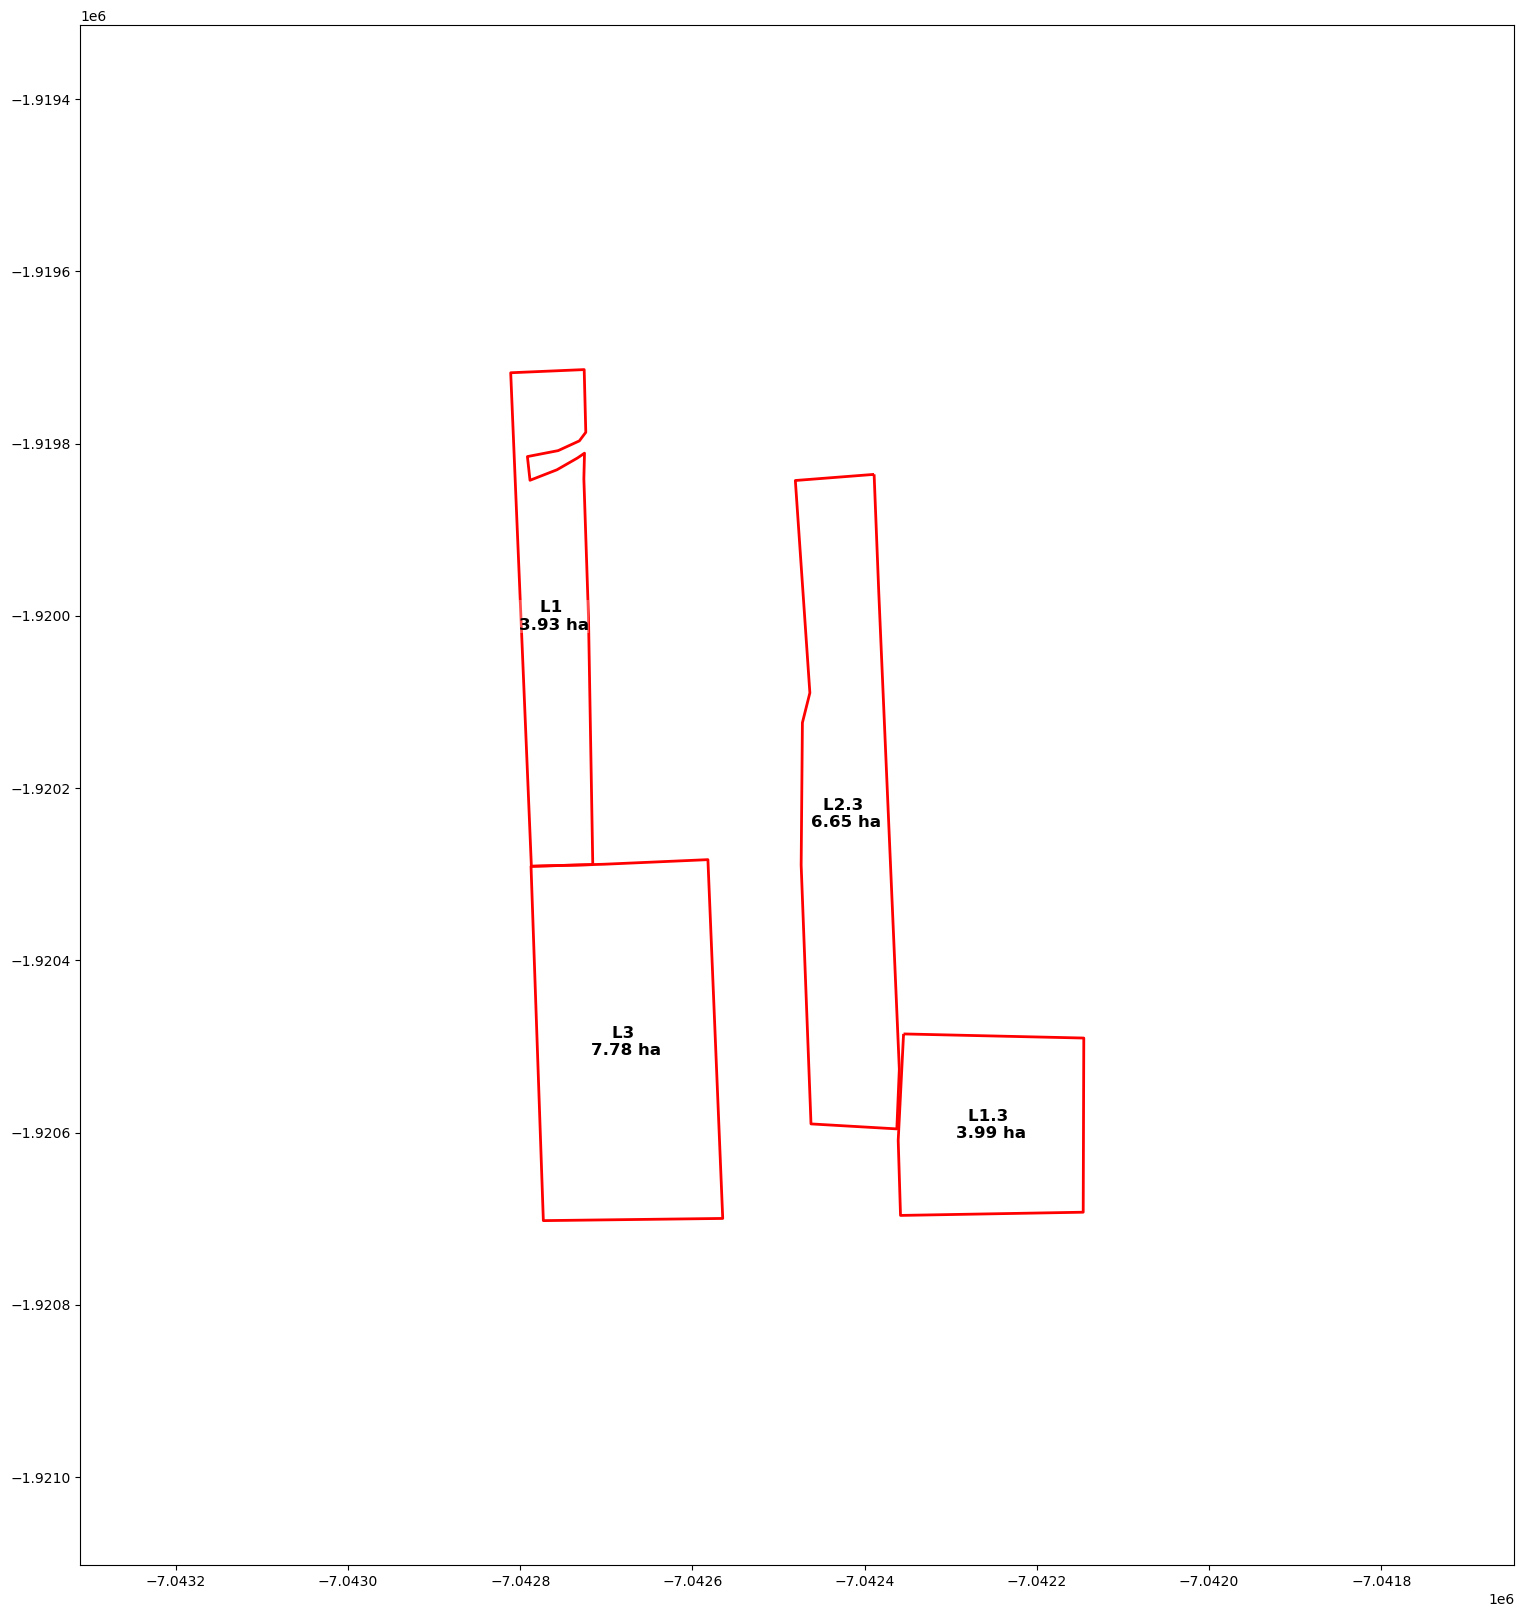

In [13]:
for i in lista:
    generar_reporte(i)
    print('======================', i)